# Medical Data Analysis with Deep Learning

This notebook demonstrates the use of deep learning for medical data analysis, supporting both **medical images** and **ECG signals** with classification and regression tasks. 

## Pipeline Overview:
1. **Data preprocessing** (image enhancement or ECG signal processing)
2. **Dataset creation and data loading** (with proper train/val/test splits)
3. **Model architecture definition** (2D CNN for images, 1D CNN for ECG)
4. **Hyperparameter tuning** (grid search optimization)
5. **Model training and evaluation** (with early stopping and metrics)
6. **Results visualization** (training curves, confusion matrices, etc.)

## Key Features:
- **Unified interface** for both image and ECG data
- **Modular design** with separate preprocessing, dataset, and model modules
- **Robust ECG processing** including PhysioNet format support
- **Comprehensive evaluation** with classification and regression metrics

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import json

# Import image processing functions
from preprocessing import (
    process_single_image, visualize_preprocessing, process_all_images,
    # ECG processing functions
    read_physionet_data, process_ecg_signal, process_all_ecg_signals, preprocess_jiachen_files,
    visualize_ecg_preprocessing,
    # voice processing functions
    read_voice_data, read_voice_metadata, preprocess_voice_signal,
    process_voice_file, process_all_voice_signals, create_voice_labels_file,
    visualize_voice_preprocessing
)

# Import dataset functions
from dataset import (
    MedicalImageDataset, ECGDataset, 
    create_data_loaders, create_ecg_data_loaders, create_voice_data_loaders
)

# Import model classes
from model import MedicalCNN, ECG1DCNN, ModelTrainer, Voice1DCNN

# Import hyperparameter tuning
from hyperparameter_tuning import HyperparameterTuner

## Configuration

Set up the configuration for the experiment. You can modify these parameters to experiment with different settings.

In [3]:
student_name = '' # don't change this

# Experiment configuration
config = {
    'data_type': 'image',  # 'image', 'voice' or 'ECG' - determines data processing pipeline
    'task_type': 'regression',  # 'classification' or 'regression'
    'num_classes': 2,  # for classification only
    'image_dir': f'./data/{student_name}after_processed',
    'labels_file': f'./data/{student_name}labels.csv',
    'batch_size': 32,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'random_seed': 42,
    'early_stopping_patience': 15,
    'save_dir': './results',
    
    # ECG-specific parameters
    'ecg_max_length': 500,  # Target sequence length for ECG signals (uniform sampling)
    
    # voice-specific parameters
    'voice_max_length': 500,  # 5 seconds at 8kHz
    'target_variable': 'Voice Handicap Index (VHI) Score',  # 'VHI Score', 'RSI Score', 'Diagnosis'
    
    # Grid search parameters
    'grid_search': {
        'num_conv_layers': [3, 2],
        'conv_channels': [64, 32],
        'fc_layers': [[512], [64, 32]],  # , [1024, 256, 64]
        'learning_rate': [0.01, 0.001,0.0003] # , 0.0001
    }
}

# class_nms = {
#     6: 'Frog',
#     9: 'Truck',
#     4: 'Deer',
#     1: 'Automobile',
#     2: 'Bird',
#     7: 'Horse',
#     8: 'Ship',
#     3: 'Cat',
#     5: 'Dog',
#     0: 'Airplane'
#     }

# directly set the class names according to your data
class_nms = {
    0: 'Normal',
    1: 'Abnormal'
    }

## Data Preprocessing

Let's preprocess the data based on the data type (image or ECG signals).

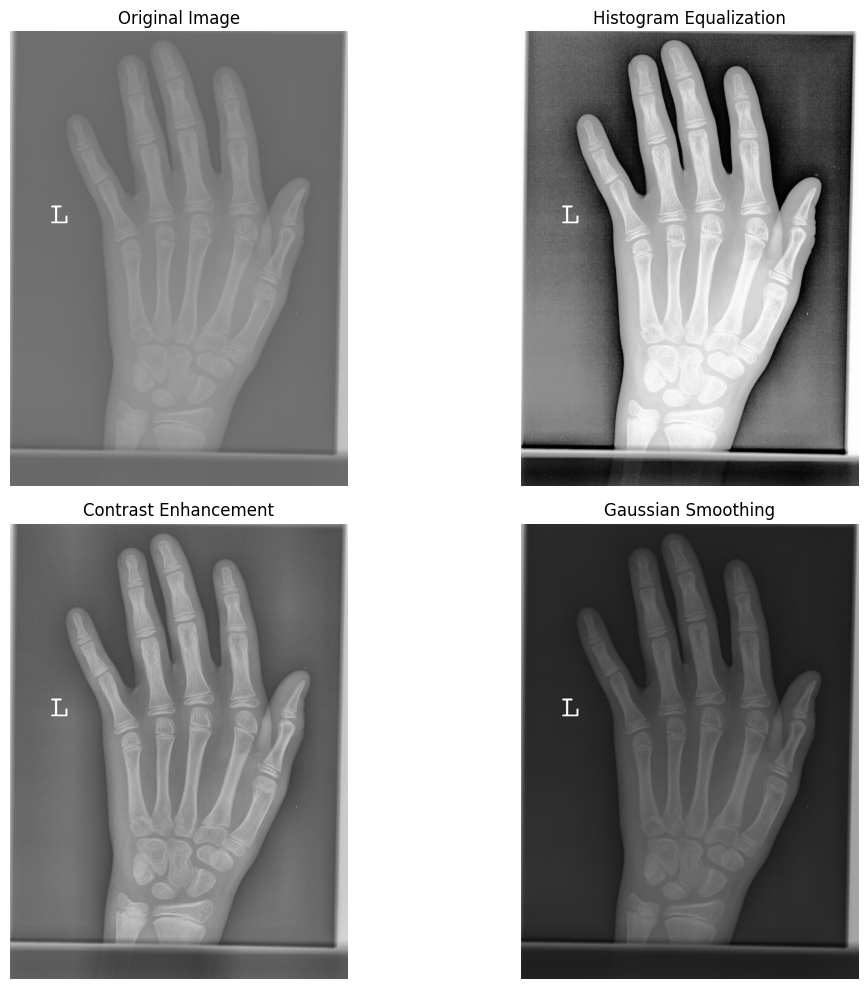

In [4]:
if config['data_type'] == 'image':
    # Visualize preprocessing on a sample image
    ori_image_dir = f'./data/{student_name}ori_images'
    sample_image_path = list(Path(ori_image_dir).glob('*.png'))[0]
    visualize_preprocessing(sample_image_path)
    
elif config['data_type'] == 'ECG':
    label_df = pd.read_csv(config['labels_file'])
    label_df.columns = [x.strip() for x in label_df.columns]
    label_df['y'] = label_df['cause of death'].astype(int)
    # label_df['id'] = label_df['id'].apply(lambda x: x.replace('Jiachen_', 'P'))
    label_df.to_csv(config['labels_file'], index=False)
    
    # ECG data directories
    ecg_raw_dir = f'./data/{student_name}ori_images'
    ecg_processed_dir = f'./data/{student_name}after_processed'
    
    # Handle Jiachen's special file naming
    preprocess_jiachen_files(ecg_raw_dir, config['labels_file'])
    
    # Process all ECG files
    processed_count = process_all_ecg_signals(
        ecg_raw_dir, 
        ecg_processed_dir, 
        config['ecg_max_length']
    )
    
    # Visualize preprocessing on a sample ECG
    sample_files = list(Path(ecg_raw_dir).glob('*.dat'))
    if sample_files:
        sample_dat = sample_files[0]
        sample_hea = Path(str(sample_dat).replace('.dat', '.hea'))
        if sample_hea.exists():
            visualize_ecg_preprocessing(sample_dat, sample_hea, config['ecg_max_length'])
        else:
            print(f"Warning: Header file {sample_hea} not found")
    else:
        print("No ECG files found for visualization")

elif config['data_type'] == 'voice':
    # voice data directories
    voice_raw_dir = f'./data/{student_name}ori_images'
    voice_processed_dir = f'./data/{student_name}after_processed'
    
    # Process all voice files
    processed_count = process_all_voice_signals(
        voice_raw_dir, 
        voice_processed_dir, 
        config['voice_max_length']
    )

    # Create labels file
    labels_df = create_voice_labels_file(
        voice_raw_dir, 
        config['labels_file'], 
        config['target_variable']
    )
    print(labels_df.head())
    labels_df.to_csv(config['labels_file'], index=False)

    # Visualize preprocessing on a sample voice signal
    sample_files = list(Path(voice_raw_dir).glob('*.dat'))
    if sample_files:
        sample_dat = sample_files[0]
        sample_hea = Path(str(sample_dat).replace('.dat', '.hea'))
        sample_txt = Path(str(sample_dat).replace('.dat', '.txt'))
        if sample_hea.exists() and sample_txt.exists():
            visualize_voice_preprocessing(sample_txt, sample_hea, config['voice_max_length'], 3)
        else:
            print(f"Warning: Header file {sample_hea} not found")
    else:
        print("No voice files found for visualization")


Now, let's process all images in the dataset:

In [4]:
if config['data_type'] == 'image':
    # Process all images
    input_dir = ori_image_dir
    output_dir = config['image_dir']
    target_size = (224, 224)  # Standard size for many CNN architectures

    process_all_images(input_dir, output_dir, target_size)

## Data Loading

Create data loaders for training, validation, and testing.

In [5]:
# Create data loaders based on data type
if config['data_type'] == 'image':
    data_loaders = create_data_loaders(
        data_dir=config['image_dir'],
        labels_file=config['labels_file'],
        task_type=config['task_type'],
        batch_size=config['batch_size'],
        train_ratio=config['train_ratio'],
        val_ratio=config['val_ratio'],
        test_ratio=config['test_ratio'],
        random_seed=config['random_seed']
    )
elif config['data_type'] == 'ECG':
    # For ECG data, use processed ECG data directory
    data_loaders = create_ecg_data_loaders(
        data_dir=config['image_dir'],
        labels_file=config['labels_file'],
        task_type=config['task_type'],
        batch_size=config['batch_size'],
        train_ratio=config['train_ratio'],
        val_ratio=config['val_ratio'],
        test_ratio=config['test_ratio'],
        random_seed=config['random_seed']
    )
elif config['data_type'] == 'voice':
    print('Creating voice data loaders')
    data_loaders = create_voice_data_loaders(
        data_dir=config['image_dir'],
        labels_file=config['labels_file'],
        task_type=config['task_type'],
        batch_size=config['batch_size'],
        train_ratio=config['train_ratio'],
        val_ratio=config['val_ratio'],
        test_ratio=config['test_ratio'],
        random_seed=config['random_seed'],
        target_length=config['voice_max_length']
    )

train_loader, val_loader, test_loader = data_loaders['train'], data_loaders['val'], data_loaders['test']

# Print dataset sizes
print(f"Training set size: {len(data_loaders['train'].dataset)}")
print(f"Validation set size: {len(data_loaders['val'].dataset)}")
print(f"Test set size: {len(data_loaders['test'].dataset)}")
print(f"Data type: {config['data_type']}")

# Show sample data shape
sample_data, sample_label = next(iter(train_loader))
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample label shape: {sample_label.shape}")
sample_data[:3,]

Training set size: 70
Validation set size: 15
Test set size: 15
Data type: image
Sample data shape: torch.Size([32, 1, 224, 224])
Sample label shape: torch.Size([32])


tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -0.1657,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]],


        [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 0.4166,  0.4166,  0.4166,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.4166,  0.3823,  0.3823,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.4508,  0.4166,  0.3481,  ..., -2.1179, -2.1179, -2.1179]]],


        [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.117

## Grid Search

Perform grid search to find the best model architecture and hyperparameters.

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create universal hyperparameter tuner
print(f"Performing {config['data_type']} grid search...")

tuner = HyperparameterTuner(
    train_loader=train_loader,
    val_loader=val_loader,
    task_type=config['task_type'],
    model_type=config['data_type'],  # 'image' or 'ECG' or 'voice'
    num_classes=config['num_classes'],
    input_length=config.get('ecg_max_length', 5000) if config['data_type'] == 'ECG' else config.get('voice_max_length', 5000) if config['data_type'] == 'voice' else None, 
    device=device,
    save_dir=Path(config['save_dir']) / 'grid_search'
)

# Perform grid search
grid_search_results = tuner.grid_search(
    param_grid=config['grid_search'],
    num_epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience']
)

# Plot results
tuner.plot_results()

# Print best combination
print('\nBest combination:')
print(json.dumps(grid_search_results['best_combination'], indent=2))
print('\nBest validation metrics:')
print(json.dumps(grid_search_results['best_val_metrics'], indent=2))


Using device: cpu
Performing image grid search...

Trying combination 1/24:
{
  "num_conv_layers": 3,
  "conv_channels": 64,
  "fc_layers": [
    512
  ],
  "learning_rate": 0.01
}


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Example preds and labels [-1.8796673, -0.22681288, -1.5790534, -0.5527019, -1.1249533, -0.73037267, -2.5362082, -1.5979421, -0.64533657, -0.97400606] [180.0, 156.0, 120.0, 32.0, 192.0, 126.0, 138.0, 33.0, 113.0, 108.0]


Epochs:   0%|          | 0/30 [00:27<?, ?it/s, Train Loss=14067.3740, Val Loss=4218.3262, Train R²=-4.564, Val R²=-0.222, LR=0.010000]


Epoch [1/30]
Train Loss: 14067.3740, Train Metrics: {'mse': 14201.9208984375, 'mae': 108.25452423095703, 'r2': -4.5635457038879395}
Val Loss: 4218.3262, Val Metrics: {'mse': 4218.32568359375, 'mae': 53.973209381103516, 'r2': -0.22195374965667725}


Epochs:   3%|▎         | 1/30 [00:28<13:33, 28.06s/it, Train Loss=14067.3740, Val Loss=4218.3262, Train R²=-4.564, Val R²=-0.222, LR=0.010000]

New best model saved with validation loss: 4218.3262


Example preds and labels [-5.266549, -2.5157924, 16.40196, 17.96207, 0.6926229, 14.484493, 7.1585355, 6.4566994, 14.541667, 8.02853] [24.0, 138.0, 42.0, 94.0, 60.0, 180.0, 94.0, 96.0, 33.0, 33.0]


Epochs:   7%|▋         | 2/30 [00:56<13:17, 28.49s/it, Train Loss=12326.4548, Val Loss=3533.0864, Train R²=-3.971, Val R²=-0.023, LR=0.010000]


Epoch [2/30]
Train Loss: 12326.4548, Train Metrics: {'mse': 12689.1689453125, 'mae': 101.47528076171875, 'r2': -3.970931053161621}
Val Loss: 3533.0864, Val Metrics: {'mse': 3533.08642578125, 'mae': 49.12696075439453, 'r2': -0.023455381393432617}
New best model saved with validation loss: 3533.0864


Example preds and labels [10.240166, 23.19999, 5.3041325, 4.6339817, 4.4485726, 26.985184, 12.002272, 14.453224, 1.5993099, 30.30169] [90.0, 216.0, 140.0, 113.0, 106.0, 33.0, 162.0, 132.0, 150.0, 88.0]


Epochs:  10%|█         | 3/30 [01:26<13:01, 28.95s/it, Train Loss=11488.2386, Val Loss=6733.0269, Train R²=-3.438, Val R²=-0.950, LR=0.010000]


Epoch [3/30]
Train Loss: 11488.2386, Train Metrics: {'mse': 11329.345703125, 'mae': 94.7005386352539, 'r2': -3.4382262229919434}
Val Loss: 6733.0269, Val Metrics: {'mse': 6733.0263671875, 'mae': 70.41581726074219, 'r2': -0.9504058361053467}


Example preds and labels [29.976295, 30.223248, 46.087364, 19.248745, 38.76586, 14.367086, 19.883013, 28.805077, 10.421424, 39.898422] [132.0, 120.0, 156.0, 42.0, 126.0, 120.0, 138.0, 138.0, 138.0, 180.0]


Epochs:  13%|█▎        | 4/30 [01:54<12:27, 28.74s/it, Train Loss=9714.2194, Val Loss=4686.1748, Train R²=-2.850, Val R²=-0.357, LR=0.010000] 


Epoch [4/30]
Train Loss: 9714.2194, Train Metrics: {'mse': 9826.7392578125, 'mae': 87.26234436035156, 'r2': -2.849586248397827}
Val Loss: 4686.1748, Val Metrics: {'mse': 4686.17431640625, 'mae': 54.93290710449219, 'r2': -0.3574789762496948}


Example preds and labels [27.242167, 34.185307, 53.182465, 43.59053, 28.972918, 35.677803, 10.686911, 26.83108, 12.661227, 9.357214] [132.0, 120.0, 100.0, 132.0, 33.0, 159.0, 32.0, 126.0, 106.0, 138.0]


Epochs:  17%|█▋        | 5/30 [02:43<14:56, 35.87s/it, Train Loss=7667.7122, Val Loss=5004.2759, Train R²=-2.332, Val R²=-0.450, LR=0.010000]


Epoch [5/30]
Train Loss: 7667.7122, Train Metrics: {'mse': 8505.1142578125, 'mae': 79.77605438232422, 'r2': -2.3318445682525635}
Val Loss: 5004.2759, Val Metrics: {'mse': 5004.27587890625, 'mae': 60.7896728515625, 'r2': -0.4496258497238159}


Example preds and labels [39.5141, 79.02992, 50.434605, 6.501015, 23.309359, 33.482048, 64.9704, 27.552446, 45.11116, 23.328201] [120.0, 94.0, 192.0, 24.0, 42.0, 120.0, 126.0, 132.0, 174.0, 150.0]


Epochs:  20%|██        | 6/30 [03:26<15:21, 38.41s/it, Train Loss=6121.9446, Val Loss=4284.8066, Train R²=-1.733, Val R²=-0.241, LR=0.010000]


Epoch [6/30]
Train Loss: 6121.9446, Train Metrics: {'mse': 6975.3720703125, 'mae': 71.35311889648438, 'r2': -1.7325739860534668}
Val Loss: 4284.8066, Val Metrics: {'mse': 4284.80712890625, 'mae': 49.598087310791016, 'r2': -0.24121201038360596}
Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.


Example preds and labels [25.982803, 25.45083, 53.147133, 35.823803, 23.5914, 78.08554, 36.138313, 5.070392, 59.20657, 27.479662] [162.0, 170.0, 126.0, 113.0, 60.0, 42.0, 78.0, 12.0, 156.0, 120.0]


Epochs:  20%|██        | 6/30 [03:59<15:21, 38.41s/it, Train Loss=5995.1636, Val Loss=2748.8999, Train R²=-1.280, Val R²=0.204, LR=0.005000] 


Epoch [7/30]
Train Loss: 5995.1636, Train Metrics: {'mse': 5820.3515625, 'mae': 63.75927734375, 'r2': -1.2800993919372559}
Val Loss: 2748.8999, Val Metrics: {'mse': 2748.89990234375, 'mae': 39.77232360839844, 'r2': 0.20370572805404663}


Epochs:  23%|██▎       | 7/30 [04:00<14:11, 37.02s/it, Train Loss=5995.1636, Val Loss=2748.8999, Train R²=-1.280, Val R²=0.204, LR=0.005000]

New best model saved with validation loss: 2748.8999


Example preds and labels [97.502884, 60.22818, 121.94348, 41.693775, 34.484756, 28.392006, 44.84732, 34.208687, 27.658703, 78.41823] [192.0, 138.0, 120.0, 156.0, 33.0, 78.0, 120.0, 60.0, 21.0, 100.0]


Epochs:  23%|██▎       | 7/30 [04:49<14:11, 37.02s/it, Train Loss=4997.3314, Val Loss=2260.7058, Train R²=-1.006, Val R²=0.345, LR=0.005000]


Epoch [8/30]
Train Loss: 4997.3314, Train Metrics: {'mse': 5119.7763671875, 'mae': 58.98216247558594, 'r2': -1.0056519508361816}
Val Loss: 2260.7058, Val Metrics: {'mse': 2260.7060546875, 'mae': 38.900901794433594, 'r2': 0.3451244831085205}


Epochs:  27%|██▋       | 8/30 [04:49<14:58, 40.83s/it, Train Loss=4997.3314, Val Loss=2260.7058, Train R²=-1.006, Val R²=0.345, LR=0.005000]

New best model saved with validation loss: 2260.7058


Example preds and labels [79.636566, 38.17152, 81.56036, 130.50777, 81.44273, 57.536198, 20.698189, 55.240868, 33.810776, 100.528564] [180.0, 78.0, 132.0, 180.0, 120.0, 180.0, 21.0, 162.0, 90.0, 108.0]


Epochs:  30%|███       | 9/30 [05:22<13:23, 38.25s/it, Train Loss=5010.3683, Val Loss=2743.0632, Train R²=-0.753, Val R²=0.205, LR=0.005000]


Epoch [9/30]
Train Loss: 5010.3683, Train Metrics: {'mse': 4473.64990234375, 'mae': 54.749698638916016, 'r2': -0.7525345087051392}
Val Loss: 2743.0632, Val Metrics: {'mse': 2743.06298828125, 'mae': 38.57659149169922, 'r2': 0.20539653301239014}


Example preds and labels [92.31117, 70.115845, 42.471672, 59.94075, 22.887924, 83.476616, 58.992867, 23.884378, 69.59067, 37.15096] [120.0, 156.0, 106.0, 138.0, 21.0, 42.0, 144.0, 21.0, 162.0, 136.0]


Epochs:  30%|███       | 9/30 [05:59<13:23, 38.25s/it, Train Loss=3329.2310, Val Loss=2058.2871, Train R²=-0.558, Val R²=0.404, LR=0.005000]


Epoch [10/30]
Train Loss: 3329.2310, Train Metrics: {'mse': 3976.24365234375, 'mae': 52.28208541870117, 'r2': -0.5576777458190918}
Val Loss: 2058.2871, Val Metrics: {'mse': 2058.286865234375, 'mae': 35.79533004760742, 'r2': 0.40376073122024536}


Epochs:  33%|███▎      | 10/30 [06:00<12:43, 38.19s/it, Train Loss=3329.2310, Val Loss=2058.2871, Train R²=-0.558, Val R²=0.404, LR=0.005000]

New best model saved with validation loss: 2058.2871


Example preds and labels [71.57816, 49.579823, 13.713457, 41.576313, 113.38419, 93.559906, 32.319862, 12.380843, 62.63084, 53.822968] [156.0, 82.0, 32.0, 88.0, 96.0, 138.0, 54.0, 21.0, 216.0, 94.0]


Epochs:  33%|███▎      | 10/30 [06:46<12:43, 38.19s/it, Train Loss=3110.2151, Val Loss=2047.1168, Train R²=-0.355, Val R²=0.407, LR=0.005000]


Epoch [11/30]
Train Loss: 3110.2151, Train Metrics: {'mse': 3457.88330078125, 'mae': 46.44662094116211, 'r2': -0.35461199283599854}
Val Loss: 2047.1168, Val Metrics: {'mse': 2047.116943359375, 'mae': 31.68361473083496, 'r2': 0.4069964289665222}


Epochs:  37%|███▋      | 11/30 [06:47<12:56, 40.89s/it, Train Loss=3110.2151, Val Loss=2047.1168, Train R²=-0.355, Val R²=0.407, LR=0.005000]

New best model saved with validation loss: 2047.1168


Example preds and labels [18.808794, 10.762656, 24.675167, 42.203094, 89.94915, 122.79376, 8.027517, 92.63136, 76.74462, 20.08269] [24.0, 12.0, 24.0, 21.0, 120.0, 120.0, 54.0, 84.0, 144.0, 32.0]


Epochs:  40%|████      | 12/30 [07:33<12:42, 42.37s/it, Train Loss=4059.8877, Val Loss=3633.3877, Train R²=-0.179, Val R²=-0.053, LR=0.005000]


Epoch [12/30]
Train Loss: 4059.8877, Train Metrics: {'mse': 3009.691162109375, 'mae': 45.40070343017578, 'r2': -0.17903447151184082}
Val Loss: 3633.3877, Val Metrics: {'mse': 3633.3876953125, 'mae': 48.6920280456543, 'r2': -0.05251049995422363}


Example preds and labels [54.614876, 84.86835, 44.23684, 35.271973, 97.912315, 66.35829, 123.7744, 118.081985, 68.89952, 42.74284] [57.0, 132.0, 120.0, 54.0, 42.0, 96.0, 180.0, 156.0, 156.0, 60.0]


Epochs:  43%|████▎     | 13/30 [08:19<12:20, 43.59s/it, Train Loss=3810.4119, Val Loss=4881.5176, Train R²=0.058, Val R²=-0.414, LR=0.005000] 


Epoch [13/30]
Train Loss: 3810.4119, Train Metrics: {'mse': 2404.198974609375, 'mae': 39.160552978515625, 'r2': 0.058164775371551514}
Val Loss: 4881.5176, Val Metrics: {'mse': 4881.517578125, 'mae': 55.868080139160156, 'r2': -0.41406548023223877}


Example preds and labels [26.807999, 79.80113, 84.72876, 61.83406, 31.58158, 96.91156, 33.574165, 43.44009, 25.158428, 109.15799] [54.0, 162.0, 165.0, 120.0, 106.0, 156.0, 54.0, 88.0, 12.0, 96.0]


Epochs:  47%|████▋     | 14/30 [08:51<10:41, 40.12s/it, Train Loss=2484.7076, Val Loss=3252.8416, Train R²=0.119, Val R²=0.058, LR=0.005000] 


Epoch [14/30]
Train Loss: 2484.7076, Train Metrics: {'mse': 2249.39306640625, 'mae': 37.33882522583008, 'r2': 0.11880916357040405}
Val Loss: 3252.8416, Val Metrics: {'mse': 3252.841064453125, 'mae': 39.17949295043945, 'r2': 0.05772531032562256}


Example preds and labels [61.97779, 93.66983, 91.056175, 101.14284, 39.547085, 101.00955, 101.947586, 88.48894, 79.18086, 76.22701] [84.0, 120.0, 120.0, 180.0, 36.0, 100.0, 120.0, 57.0, 150.0, 170.0]


Epochs:  50%|█████     | 15/30 [09:18<09:03, 36.26s/it, Train Loss=1351.6542, Val Loss=4819.3540, Train R²=0.451, Val R²=-0.396, LR=0.005000]


Epoch [15/30]
Train Loss: 1351.6542, Train Metrics: {'mse': 1401.841796875, 'mae': 28.947195053100586, 'r2': 0.45083409547805786}
Val Loss: 4819.3540, Val Metrics: {'mse': 4819.35400390625, 'mae': 54.73445510864258, 'r2': -0.39605820178985596}
Epoch 00015: reducing learning rate of group 0 to 2.5000e-03.


Example preds and labels [98.49182, 106.637146, 43.915863, 193.57013, 116.84766, 91.71048, 100.97507, 95.59688, 77.300735, 130.8979] [159.0, 120.0, 54.0, 180.0, 120.0, 120.0, 140.0, 138.0, 120.0, 144.0]


Epochs:  53%|█████▎    | 16/30 [09:46<07:50, 33.59s/it, Train Loss=1372.8099, Val Loss=6569.4375, Train R²=0.510, Val R²=-0.903, LR=0.002500]


Epoch [16/30]
Train Loss: 1372.8099, Train Metrics: {'mse': 1250.966796875, 'mae': 27.654296875, 'r2': 0.5099387168884277}
Val Loss: 6569.4375, Val Metrics: {'mse': 6569.4375, 'mae': 67.25911712646484, 'r2': -0.9030177593231201}


Example preds and labels [83.6658, 31.56268, 135.4978, 116.52314, 73.105194, 96.668365, 94.83589, 25.711143, 83.20749, 102.93967] [90.0, 21.0, 162.0, 120.0, 156.0, 108.0, 140.0, 24.0, 42.0, 162.0]


Epochs:  57%|█████▋    | 17/30 [10:13<06:51, 31.66s/it, Train Loss=1442.8818, Val Loss=5733.2266, Train R²=0.446, Val R²=-0.661, LR=0.002500]


Epoch [17/30]
Train Loss: 1442.8818, Train Metrics: {'mse': 1415.2410888671875, 'mae': 30.33738899230957, 'r2': 0.44558489322662354}
Val Loss: 5733.2266, Val Metrics: {'mse': 5733.22705078125, 'mae': 59.65995407104492, 'r2': -0.660786509513855}


Example preds and labels [75.67775, 195.7373, 122.11252, 46.12118, 108.095245, 59.46675, 85.339195, 161.95277, 38.44582, 132.47968] [120.0, 138.0, 100.0, 42.0, 120.0, 54.0, 106.0, 159.0, 54.0, 192.0]


Epochs:  60%|██████    | 18/30 [10:40<06:03, 30.32s/it, Train Loss=1228.1818, Val Loss=5461.0688, Train R²=0.468, Val R²=-0.582, LR=0.002500]


Epoch [18/30]
Train Loss: 1228.1818, Train Metrics: {'mse': 1357.759033203125, 'mae': 28.593759536743164, 'r2': 0.468103289604187}
Val Loss: 5461.0688, Val Metrics: {'mse': 5461.06884765625, 'mae': 57.129920959472656, 'r2': -0.5819483995437622}


Example preds and labels [149.30823, 19.003521, 144.24594, 87.10274, 25.53007, 93.72252, 91.659676, 132.28442, 58.34755, 100.394424] [120.0, 12.0, 156.0, 60.0, 36.0, 84.0, 140.0, 180.0, 126.0, 180.0]


Epochs:  63%|██████▎   | 19/30 [11:08<05:23, 29.45s/it, Train Loss=1527.0869, Val Loss=5008.6274, Train R²=0.414, Val R²=-0.451, LR=0.002500]


Epoch [19/30]
Train Loss: 1527.0869, Train Metrics: {'mse': 1495.726806640625, 'mae': 31.818519592285156, 'r2': 0.4140549302101135}
Val Loss: 5008.6274, Val Metrics: {'mse': 5008.62744140625, 'mae': 57.53392028808594, 'r2': -0.4508863687515259}
Epoch 00019: reducing learning rate of group 0 to 1.2500e-03.


Example preds and labels [88.81068, 27.434479, 143.97435, 163.88373, 63.847282, 47.96473, 138.5608, 46.404823, 76.11811, 59.5684] [170.0, 21.0, 138.0, 156.0, 33.0, 84.0, 168.0, 24.0, 60.0, 33.0]


Epochs:  67%|██████▋   | 20/30 [11:35<04:47, 28.79s/it, Train Loss=1480.7118, Val Loss=3130.3315, Train R²=0.488, Val R²=0.093, LR=0.001250] 


Epoch [20/30]
Train Loss: 1480.7118, Train Metrics: {'mse': 1306.5018310546875, 'mae': 29.652877807617188, 'r2': 0.4881831407546997}
Val Loss: 3130.3315, Val Metrics: {'mse': 3130.33154296875, 'mae': 43.23577117919922, 'r2': 0.09321361780166626}


Example preds and labels [93.965324, 27.754236, 122.95082, 24.271023, 198.8438, 99.18549, 139.47156, 106.72995, 23.72659, 177.4524] [90.0, 32.0, 120.0, 12.0, 132.0, 136.0, 144.0, 42.0, 24.0, 138.0]


Epochs:  70%|███████   | 21/30 [12:02<04:14, 28.31s/it, Train Loss=1939.7328, Val Loss=2418.6287, Train R²=0.483, Val R²=0.299, LR=0.001250]


Epoch [21/30]
Train Loss: 1939.7328, Train Metrics: {'mse': 1320.391357421875, 'mae': 27.633773803710938, 'r2': 0.4827418923377991}
Val Loss: 2418.6287, Val Metrics: {'mse': 2418.628662109375, 'mae': 37.31291198730469, 'r2': 0.2993778586387634}


Example preds and labels [119.45026, 137.44623, 48.99087, 98.045715, 75.28624, 140.10382, 99.25719, 151.14023, 61.385887, 87.17255] [132.0, 174.0, 36.0, 126.0, 156.0, 156.0, 90.0, 165.0, 21.0, 94.0]


Epochs:  70%|███████   | 21/30 [12:29<04:14, 28.31s/it, Train Loss=1269.3533, Val Loss=1182.0906, Train R²=0.611, Val R²=0.658, LR=0.001250]


Epoch [22/30]
Train Loss: 1269.3533, Train Metrics: {'mse': 994.1621704101562, 'mae': 24.92201805114746, 'r2': 0.6105409264564514}
Val Loss: 1182.0906, Val Metrics: {'mse': 1182.0906982421875, 'mae': 27.499420166015625, 'r2': 0.6575750112533569}


Epochs:  73%|███████▎  | 22/30 [12:30<03:44, 28.12s/it, Train Loss=1269.3533, Val Loss=1182.0906, Train R²=0.611, Val R²=0.658, LR=0.001250]

New best model saved with validation loss: 1182.0906


Example preds and labels [122.54651, 72.66955, 125.105, 70.63362, 166.56152, 167.26227, 139.54382, 147.5587, 210.48676, 8.781541] [120.0, 57.0, 162.0, 42.0, 180.0, 132.0, 156.0, 138.0, 180.0, 12.0]


Epochs:  77%|███████▋  | 23/30 [12:57<03:15, 27.89s/it, Train Loss=914.2245, Val Loss=1925.3385, Train R²=0.646, Val R²=0.442, LR=0.001250] 


Epoch [23/30]
Train Loss: 914.2245, Train Metrics: {'mse': 902.7037963867188, 'mae': 24.692962646484375, 'r2': 0.646369457244873}
Val Loss: 1925.3385, Val Metrics: {'mse': 1925.33837890625, 'mae': 33.13133239746094, 'r2': 0.4422729015350342}


Example preds and labels [75.091934, 66.47286, 74.29222, 54.732704, 106.92514, 116.56917, 53.33658, 98.21785, 197.61848, 163.78395] [60.0, 94.0, 36.0, 57.0, 126.0, 132.0, 24.0, 138.0, 180.0, 156.0]


Epochs:  80%|████████  | 24/30 [13:24<02:46, 27.73s/it, Train Loss=967.2506, Val Loss=2075.0413, Train R²=0.624, Val R²=0.399, LR=0.001250]


Epoch [24/30]
Train Loss: 967.2506, Train Metrics: {'mse': 960.8810424804688, 'mae': 24.41064453125, 'r2': 0.6235787272453308}
Val Loss: 2075.0413, Val Metrics: {'mse': 2075.040771484375, 'mae': 34.79975128173828, 'r2': 0.39890748262405396}


Example preds and labels [129.97147, 86.951126, 123.13896, 136.40685, 67.803116, 104.76897, 136.80093, 161.42688, 131.92294, 109.983536] [156.0, 120.0, 120.0, 120.0, 57.0, 106.0, 162.0, 159.0, 108.0, 90.0]


Epochs:  83%|████████▎ | 25/30 [13:52<02:18, 27.68s/it, Train Loss=867.9780, Val Loss=1219.2697, Train R²=0.643, Val R²=0.647, LR=0.001250]


Epoch [25/30]
Train Loss: 867.9780, Train Metrics: {'mse': 910.7552490234375, 'mae': 24.445655822753906, 'r2': 0.6432152986526489}
Val Loss: 1219.2697, Val Metrics: {'mse': 1219.269775390625, 'mae': 30.391027450561523, 'r2': 0.6468050479888916}


Example preds and labels [111.78737, 147.15584, 198.85825, 75.87721, 103.92653, 88.43633, 160.73715, 92.37439, 130.84444, 154.76138] [90.0, 138.0, 165.0, 84.0, 42.0, 113.0, 159.0, 180.0, 57.0, 156.0]


Epochs:  87%|████████▋ | 26/30 [14:20<01:50, 27.72s/it, Train Loss=1414.4248, Val Loss=2175.0010, Train R²=0.536, Val R²=0.370, LR=0.001250]


Epoch [26/30]
Train Loss: 1414.4248, Train Metrics: {'mse': 1183.531982421875, 'mae': 27.643749237060547, 'r2': 0.5363560914993286}
Val Loss: 2175.0010, Val Metrics: {'mse': 2175.00048828125, 'mae': 34.12431716918945, 'r2': 0.36995142698287964}
Epoch 00026: reducing learning rate of group 0 to 6.2500e-04.


Example preds and labels [150.88458, 99.99801, 87.50163, 77.44682, 140.48703, 63.519043, 61.959534, 112.01725, 113.26796, 48.845867] [165.0, 60.0, 60.0, 60.0, 180.0, 106.0, 36.0, 106.0, 140.0, 82.0]


Epochs:  90%|█████████ | 27/30 [14:48<01:23, 27.82s/it, Train Loss=1006.1738, Val Loss=1859.6672, Train R²=0.638, Val R²=0.461, LR=0.000625]


Epoch [27/30]
Train Loss: 1006.1738, Train Metrics: {'mse': 924.2501831054688, 'mae': 25.15924835205078, 'r2': 0.6379287242889404}
Val Loss: 1859.6672, Val Metrics: {'mse': 1859.6673583984375, 'mae': 34.011077880859375, 'r2': 0.46129631996154785}


Example preds and labels [162.74738, 71.01863, 197.93192, 130.75795, 97.84527, 32.05718, 70.843094, 104.7319, 111.33853, 131.93549] [165.0, 106.0, 192.0, 156.0, 113.0, 54.0, 42.0, 84.0, 88.0, 150.0]


Epochs:  93%|█████████▎| 28/30 [15:16<00:55, 27.78s/it, Train Loss=677.9317, Val Loss=1413.6971, Train R²=0.699, Val R²=0.590, LR=0.000625] 


Epoch [28/30]
Train Loss: 677.9317, Train Metrics: {'mse': 768.4741821289062, 'mae': 22.33287239074707, 'r2': 0.6989532709121704}
Val Loss: 1413.6971, Val Metrics: {'mse': 1413.697021484375, 'mae': 27.261608123779297, 'r2': 0.5904839038848877}


Example preds and labels [124.39843, 34.263317, 51.014816, 165.58905, 144.93456, 117.89937, 93.22613, 142.82574, 154.58844, 17.497578] [180.0, 32.0, 21.0, 165.0, 156.0, 138.0, 120.0, 108.0, 168.0, 24.0]


Epochs:  97%|█████████▋| 29/30 [15:43<00:27, 27.67s/it, Train Loss=1158.5874, Val Loss=1677.3944, Train R²=0.653, Val R²=0.514, LR=0.000625]


Epoch [29/30]
Train Loss: 1158.5874, Train Metrics: {'mse': 885.1268920898438, 'mae': 22.51122283935547, 'r2': 0.653255045413971}
Val Loss: 1677.3944, Val Metrics: {'mse': 1677.39453125, 'mae': 34.72874069213867, 'r2': 0.5140966176986694}


Example preds and labels [97.242874, 81.37483, 132.86215, 141.84882, 75.06804, 69.96512, 34.12761, 96.0542, 155.83434, 28.184044] [180.0, 94.0, 168.0, 136.0, 106.0, 94.0, 24.0, 138.0, 170.0, 33.0]


Epochs: 100%|██████████| 30/30 [16:11<00:00, 32.37s/it, Train Loss=834.7098, Val Loss=1970.2952, Train R²=0.669, Val R²=0.429, LR=0.000625] 



Epoch [30/30]
Train Loss: 834.7098, Train Metrics: {'mse': 844.7977905273438, 'mae': 22.89921760559082, 'r2': 0.669053852558136}
Val Loss: 1970.2952, Val Metrics: {'mse': 1970.2952880859375, 'mae': 37.578922271728516, 'r2': 0.4292498826980591}
Epoch 00030: reducing learning rate of group 0 to 3.1250e-04.

Trying combination 2/24:
{
  "num_conv_layers": 3,
  "conv_channels": 64,
  "fc_layers": [
    512
  ],
  "learning_rate": 0.0001
}


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Example preds and labels [-1.094856, 1.774317, -0.7333321, -0.11950418, 0.121002436, -0.58065283, -0.35803503, 0.19428211, 0.2304095, 0.91224825] [21.0, 138.0, 94.0, 84.0, 96.0, 88.0, 84.0, 42.0, 162.0, 174.0]


Epochs:   0%|          | 0/30 [00:28<?, ?it/s, Train Loss=13285.7617, Val Loss=13349.0342, Train R²=-4.617, Val R²=-2.867, LR=0.000100]


Epoch [1/30]
Train Loss: 13285.7617, Train Metrics: {'mse': 14339.150390625, 'mae': 108.6333236694336, 'r2': -4.61730432510376}
Val Loss: 13349.0342, Val Metrics: {'mse': 13349.03515625, 'mae': 99.62397766113281, 'r2': -2.8669142723083496}


Epochs:   3%|▎         | 1/30 [00:28<13:45, 28.48s/it, Train Loss=13285.7617, Val Loss=13349.0342, Train R²=-4.617, Val R²=-2.867, LR=0.000100]

New best model saved with validation loss: 13349.0342


Example preds and labels [0.6755355, -1.4989438, 3.08083, -2.8536463, 2.3216667, -0.4575818, 0.414282, 2.0353427, -0.40482938, 2.938645] [33.0, 21.0, 94.0, 84.0, 156.0, 162.0, 106.0, 33.0, 162.0, 54.0]


Epochs:   7%|▋         | 2/30 [00:56<13:03, 27.99s/it, Train Loss=14517.7695, Val Loss=13642.2852, Train R²=-4.593, Val R²=-2.952, LR=0.000100]


Epoch [2/30]
Train Loss: 14517.7695, Train Metrics: {'mse': 14277.88671875, 'mae': 108.43316650390625, 'r2': -4.593305587768555}
Val Loss: 13642.2852, Val Metrics: {'mse': 13642.283203125, 'mae': 101.06184387207031, 'r2': -2.951861619949341}


Example preds and labels [1.7803658, -2.2961655, 3.984076, -3.5849872, 0.4507168, 0.9576091, 2.4369552, -1.5407681, 3.7870083, 2.6250658] [159.0, 82.0, 120.0, 36.0, 60.0, 180.0, 33.0, 106.0, 156.0, 132.0]


Epochs:  10%|█         | 3/30 [01:24<12:36, 28.00s/it, Train Loss=15140.1045, Val Loss=14100.9600, Train R²=-4.569, Val R²=-3.085, LR=0.000100]


Epoch [3/30]
Train Loss: 15140.1045, Train Metrics: {'mse': 14215.865234375, 'mae': 108.40811157226562, 'r2': -4.5690083503723145}
Val Loss: 14100.9600, Val Metrics: {'mse': 14100.9599609375, 'mae': 103.24479675292969, 'r2': -3.0847301483154297}


Example preds and labels [-2.2594187, -0.49462655, -1.397106, -4.4770327, 0.8733518, 6.1393404, 3.6193721, 2.1871293, -0.4612861, 0.6435682] [159.0, 138.0, 144.0, 32.0, 88.0, 180.0, 180.0, 126.0, 113.0, 138.0]


Epochs:  13%|█▎        | 4/30 [01:51<12:04, 27.87s/it, Train Loss=14070.2933, Val Loss=14528.9170, Train R²=-4.547, Val R²=-3.209, LR=0.000100]


Epoch [4/30]
Train Loss: 14070.2933, Train Metrics: {'mse': 14160.1220703125, 'mae': 108.3829345703125, 'r2': -4.5471720695495605}
Val Loss: 14528.9170, Val Metrics: {'mse': 14528.91796875, 'mae': 105.46279907226562, 'r2': -3.2086997032165527}


Example preds and labels [4.5974097, -2.7860103, -3.6092532, 5.5347004, -0.28034008, 4.4018197, 0.08763915, 1.1054072, 2.9918234, 5.376199] [180.0, 82.0, 24.0, 180.0, 170.0, 108.0, 96.0, 54.0, 159.0, 156.0]


Epochs:  17%|█▋        | 5/30 [02:20<11:39, 27.99s/it, Train Loss=14607.2676, Val Loss=14926.1973, Train R²=-4.534, Val R²=-3.324, LR=0.000100]


Epoch [5/30]
Train Loss: 14607.2676, Train Metrics: {'mse': 14126.2138671875, 'mae': 108.27811431884766, 'r2': -4.5338873863220215}
Val Loss: 14926.1973, Val Metrics: {'mse': 14926.1982421875, 'mae': 107.33704376220703, 'r2': -3.3237829208374023}
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


Example preds and labels [0.9358095, -1.1407142, 0.20401435, 4.58051, -8.928787, 0.35045117, -3.635076, 1.629204, -0.8418485, -2.0565212] [33.0, 192.0, 60.0, 120.0, 24.0, 138.0, 113.0, 94.0, 54.0, 150.0]


Epochs:  20%|██        | 6/30 [02:47<11:07, 27.82s/it, Train Loss=14160.4678, Val Loss=15328.7725, Train R²=-4.544, Val R²=-3.440, LR=0.000050]


Epoch [6/30]
Train Loss: 14160.4678, Train Metrics: {'mse': 14152.9462890625, 'mae': 108.28938293457031, 'r2': -4.5443596839904785}
Val Loss: 15328.7725, Val Metrics: {'mse': 15328.7724609375, 'mae': 109.18855285644531, 'r2': -3.440399646759033}


Example preds and labels [-3.0778074, 3.4282904, -1.2544528, 2.7033703, 2.0836587, 0.114001095, 3.4449787, 3.1263766, -4.807575, 3.5213995] [54.0, 33.0, 150.0, 108.0, 180.0, 144.0, 174.0, 120.0, 170.0, 156.0]


## Train Best Model

Train the model with the best hyperparameters found during grid search.

In [6]:
# Get best parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

grid_search_res_path = 'results/grid_search/grid_search_summary.json'
with open(grid_search_res_path, 'r') as f:
    grid_search_results = json.load(f)

best_params = grid_search_results['best_combination']

# Create model with best parameters based on data type
if config['data_type'] == 'image':
    model = MedicalCNN(
        task_type=config['task_type'],
        num_classes=config['num_classes'],
        num_conv_layers=best_params['num_conv_layers'],
        conv_channels=best_params['conv_channels'],
        fc_layers=best_params['fc_layers']
    )
elif config['data_type'] == 'ECG':
    model = ECG1DCNN(
        task_type=config['task_type'],
        num_classes=config['num_classes'],
        input_length=config['ecg_max_length'],
        num_conv_layers=best_params['num_conv_layers'],
        conv_channels=best_params['conv_channels'],
        fc_layers=best_params['fc_layers']
    )
elif config['data_type'] == 'voice':
    # Create voice model with best parameters
    model = Voice1DCNN(
        task_type=config['task_type'],
        num_classes=config['num_classes'],
        input_length=config['voice_max_length'],
        num_conv_layers=best_params['num_conv_layers'],
        conv_channels=best_params['conv_channels'],
        fc_layers=best_params['fc_layers']
    )

# Define loss function and optimizer
if config['task_type'] == 'classification':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Initialize trainer
trainer = ModelTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    task_type=config['task_type']
)

# Check if best model exists, if so, load it; otherwise, train and save
from pathlib import Path
best_model_path = Path(config['save_dir']) / 'best_model' / 'best_model.pth'
if best_model_path.exists():
    print(f"Found existing best model at {best_model_path}, loading...")
    trainer.load_model(str(best_model_path))
    history = None  # No new training history
else:
    print("No existing best model found, training...")
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=config['num_epochs'],
        save_dir=Path(config['save_dir']) / 'best_model',
        early_stopping_patience=15
    )
    # Plot training history
    trainer.plot_training_history(Path(config['save_dir']) / 'best_model')

# Set class names for classification tasks
if config['task_type'] == 'classification':
    # Define class name mapping
    class_names = class_nms # Modify according to your specific classes
    # Or you can set it according to your needs, for example:
    # class_names = {0: 'aa', 1: 'bb'}
    
    # Set class names to trainer
    trainer.set_class_names(class_names)
    print(f"Class names set: {class_names}")

# Save the trainer state for later use
best_trainer = trainer


Using device: cpu
Found existing best model at results/best_model/best_model.pth, loading...
Class names set: {6: 'Frog', 9: 'Truck', 4: 'Deer', 1: 'Automobile', 2: 'Bird', 7: 'Horse', 8: 'Ship', 3: 'Cat', 5: 'Dog', 0: 'Airplane'}


## Evaluation

Evaluate the best model on the test set.

In [7]:
# Evaluate on test set
print("Evaluating model on test set...")
test_metrics = trainer.evaluate(test_loader, Path(config['save_dir']) / 'best_model')
print('\nTest Set Metrics:')
print(json.dumps(test_metrics, indent=2))

# Print some debug information
print(f"\nModel device: {next(trainer.model.parameters()).device}")
print(f"Task type: {trainer.task_type}")
print(f"Test set size: {len(test_loader.dataset)}")

Evaluating model on test set...


Evaluating:   0%|                              | 0/19 [00:00<?, ?it/s]

Evaluating: 100%|██████████████████████████████| 19/19 [00:26<00:00,  1.42s/it, Samples=900/900]


Test Set Metrics:
{
  "accuracy": 0.22666666666666666,
  "precision": 0.22922859087927744,
  "recall": 0.22666666666666666,
  "f1": 0.19841066839408936
}

Model device: cpu
Task type: classification
Test set size: 900


In [9]:
# Performance comparison with traditional machine learning methods
print("="*60)
print("STARTING MODEL COMPARISON WITH TRADITIONAL ML METHODS")
print("="*60)

# Import required modules for comparison
from model import compare_models_performance

# DEBUG CONTROL - Set to True for detailed debugging information
DEBUG_MODE = False  # Change to True if you want to see detailed debug information

# Set class names for comparison (if classification task)
comparison_class_names = None
if config['task_type'] == 'classification':
    comparison_class_names = class_names  # Modify according to your classes

print(f"Configuration:")
print(f"  Task type: {config['task_type']}")
print(f"  Train set size: {len(train_loader.dataset)}")
print(f"  Validation set size: {len(val_loader.dataset)}")
print(f"  Test set size: {len(test_loader.dataset)}")
print(f"  Class names: {comparison_class_names}")
print(f"  Debug mode: {DEBUG_MODE}")
print(f"  Save directory: ./results/model_evaluation")

try:
    # Compare models performance
    comparison_results = compare_models_performance(
        best_cnn_trainer=trainer,
        train_loader=train_loader,
        val_loader=val_loader, 
        test_loader=test_loader,
        save_dir='./results/model_evaluation',
        task_type=config['task_type'],
        class_names=comparison_class_names,
        debug=DEBUG_MODE  # Control debug output
    )

    # Display comparison results
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON RESULTS")
    print("="*50)

    for model_name, metrics in comparison_results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name.upper()}: {value:.4f}")

    print(f"\nAll comparison plots saved to: ./results/model_evaluation/")
    print("Generated files:")
    if config['task_type'] == 'classification':
        print("- aupr_comparison.png (AUPR curves)")
        print("- auc_comparison.png (ROC curves)")
        print("- accuracy_comparison.png")
        print("- precision_comparison.png") 
        print("- recall_comparison.png")
        print("- f1_comparison.png")
    else:
        print("- mse_comparison.png")
        print("- mae_comparison.png")
        print("- r2_comparison.png")
    print("- model_comparison_results.json")
    
except Exception as e:
    print(f"Error during model comparison: {e}")
    if DEBUG_MODE:
        import traceback
        traceback.print_exc()

STARTING MODEL COMPARISON WITH TRADITIONAL ML METHODS
Configuration:
  Task type: classification
  Train set size: 4200
  Validation set size: 900
  Test set size: 900
  Class names: {6: 'Frog', 9: 'Truck', 4: 'Deer', 1: 'Automobile', 2: 'Bird', 7: 'Horse', 8: 'Ship', 3: 'Cat', 5: 'Dog', 0: 'Airplane'}
  Debug mode: False
  Save directory: ./results/model_evaluation


Extracting Features:   0%|                              | 0/88 [00:00<?, ?it/s]

Model comparison results saved to ./results/model_evaluation

MODEL PERFORMANCE COMPARISON RESULTS

Deep Learning (CNN):
  ACCURACY: 0.2389
  PRECISION: 0.2468
  RECALL: 0.2389
  F1: 0.2119

Random Forest:
  ACCURACY: 0.2233
  PRECISION: 0.2167
  RECALL: 0.2233
  F1: 0.2184

SVM:
  ACCURACY: 0.2633
  PRECISION: 0.2633
  RECALL: 0.2633
  F1: 0.2495

Logistic Regression:
  ACCURACY: 0.2678
  PRECISION: 0.2604
  RECALL: 0.2678
  F1: 0.2572

All comparison plots saved to: ./results/model_evaluation/
Generated files:
- aupr_comparison.png (AUPR curves)
- auc_comparison.png (ROC curves)
- accuracy_comparison.png
- precision_comparison.png
- recall_comparison.png
- f1_comparison.png
- model_comparison_results.json
